# Solving Wasserstein Gradient Flow using Sinkhorn's Algorithm
Throughout the notebook, let us adapt the following setting. For $n \in \mathbb{N}$, define $\Omega \subseteq \mathbb{R}^n$ be a compact subset of $n$ dimensional Euclidean space, and $\mathcal{P}(\Omega)$ be a space of Borel probability measures on $\Omega$. The 2-Wasserstein space is defined as a metric space of probability measures endowed with what so called a 2-Wasserstein metric $W_2: \mathcal{P}(\Omega) \times \mathcal{P}(\Omega) \to [0,\infty]$, defined as, $$W_2(\mu,\nu) = \left( \inf_{\gamma \in \Pi(\mu,\nu)} \int_{\Omega^2} \vert x-y\vert^2 d\gamma(x,y) \right)^{1/2}$$ where $\Pi(\mu,\nu) \coloneqq \{\gamma \in \mathcal{P}(\Omega^2) : \pi_{1}\sharp\gamma = \mu, \pi_{2}\sharp\gamma = \nu\}$.

In [1]:
from src.jko_lab import * # solvers
from src.utils import * # graphing utilities
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from jax import lax
import optax
from __future__ import annotations
from typing import Callable, Optional, Tuple, List
import flax.struct as flstr
Array = jnp.ndarray

## Wasserstein gradient flow
Given a functional $\mathcal{F} : \mathcal{P}_2(\Omega) \to \mathbb{R}$, a curve $(\rho_t)_{t\geq 0}$ in $\mathcal{P}_2(\Omega)$ is called a \emph{Wasserstein gradient flow} of $\mathcal{F}$ if $$\frac{d\rho_t}{dt} = - \nabla_{W_2}F(\rho_t),$$ meaning that $\rho_t$ evolves in the direction of steepest descent of $\mathcal{F}$ with respect to the $W_2$ metric. If $\rho_t$ admits a Radon-Nikodym derivative, i.e. density, this Wasserstein gradient flow corresponds to the PDE $$\partial_t \rho_t = \nabla \cdot \left( \rho_t \nabla \frac{\delta \mathcal{F}}{\delta \rho} (\rho_t) \right).$$

#### Visualization Tools
Following cells contain codes for visualizing the flow, sinkhorn's algorithm iterations, and etc.

Let us assume that $W_2^2(\rho,\rho^k) \ll 1$, that is, two probability measures $\rho$ and $\rho^k$ are similar. Then, we would like to see that if $\epsilon$ is fairly large, then it does not take that many Sinkhorn iterations to converge within $10^{-9}$ precision.

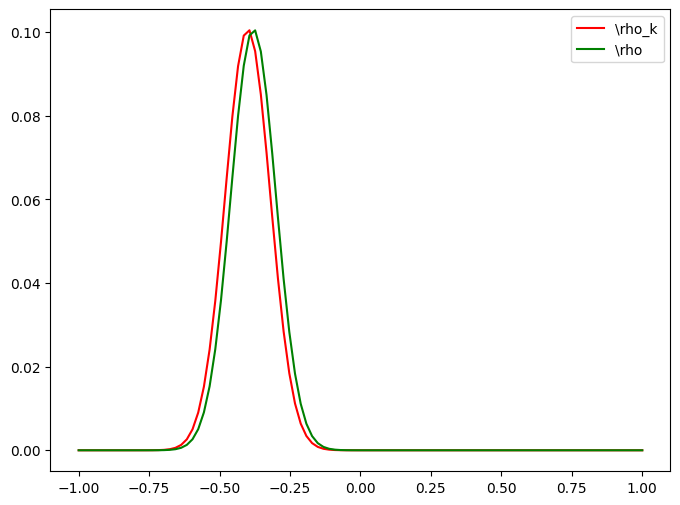

In [2]:
key = jax.random.PRNGKey(42)
n = 100

# 1D grid on [0,1]
x = jnp.linspace(0, 1, n)
C = (x[:,None] - x[None,:])**2 # cost matrix

# Target marginal rho_k (right marginal), a bimodal distribution
rho_k = jax.scipy.stats.norm.pdf(x, 0.3, 0.04)
rho_k = jnp.clip(rho_k, 1e-12, None)
rho_k = rho_k / rho_k.sum()

rho = jax.scipy.stats.norm.pdf(x, 0.3+1e-2, 0.04)
rho = rho / rho.sum()

plot_vectors(n, {
    "rho_k": rho_k,
    "rho": rho
    })

We solve the entropy-regularized optimal transport problem
$$
\arg\min \langle C, \pi\rangle + \varepsilon H(\pi)
$$
with $\mathrm{rs}(\pi)=\rho^k$, $\mathrm{cs}(\pi)=\rho$ via Sinkhorn algorithm.

In [3]:
eta = 1e-2 # JKO step size
epsilon = 1e-4 # Sinkhorn regularization parameter

# Run solver
solver = Sinkhorn(
    C=C,
    a=rho,
    b=rho_k,
    epsilon=epsilon,
    max_iters=2000,
    tol=1e-9
)

# extract outputs
pi, f, g, error, iters = solver.solve()
# print basic info
print("Column feasibility ||pi^T 1 - rho_k||:", float(jnp.linalg.norm(col_sums(pi) - rho_k)))
print(f"Convergence in {iters} iterations")
print("Mass check (should be 1):", float(rho.sum()))

Column feasibility ||pi^T 1 - rho_k||: 2.0041068779425864e-16
Convergence in 531 iterations
Mass check (should be 1): 0.9999999999999999


The performance of the algorithm is measured by the following.

Text(0.5, 1.02, 'Summary of Sinkhorn Algorithm')

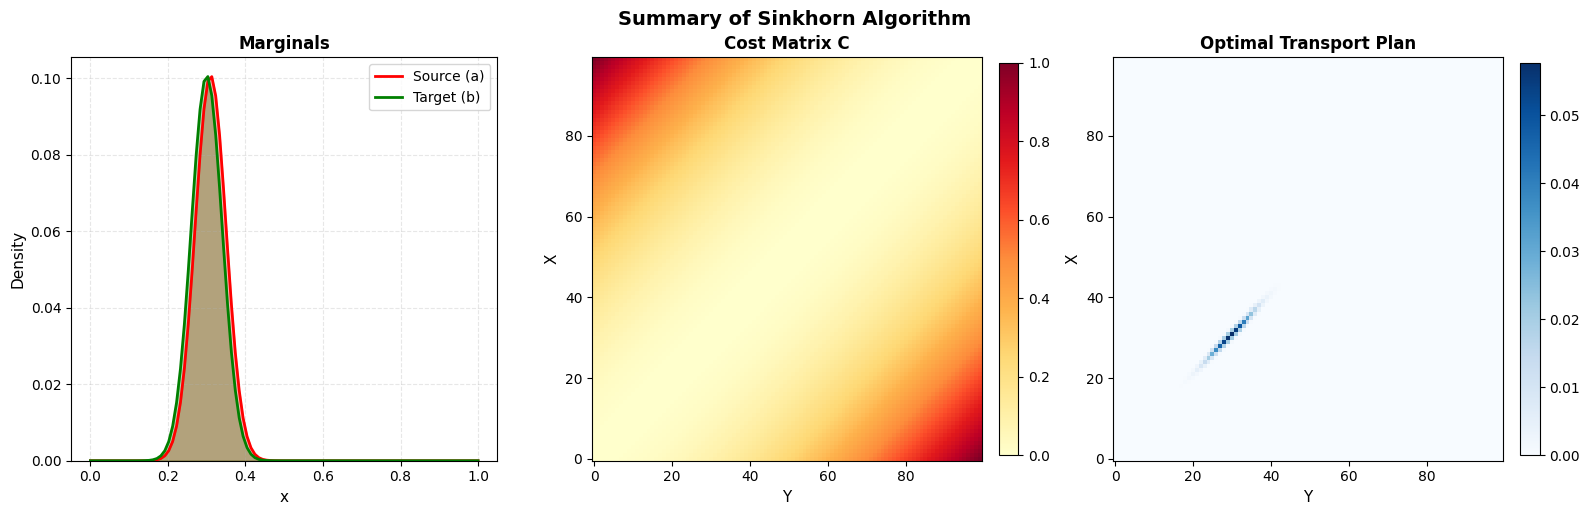

In [4]:
# Create summary
fig = plot_sinkhorn_summary(
    C=C,
    a=rho,
    b=rho_k,
    pi=pi,
    x_source=x,
    x_target=x,
    figsize=(16, 5)
)
plt.suptitle(f'Summary of Sinkhorn Algorithm', fontsize=14, fontweight='bold', y=1.02)

The following wrapper function computes squared entropy-regularized 2-Wasserstein distance using warm-start Sinkhorn's algorithm.
$$
W_{2,\epsilon}^2(\rho,\rho^k) = \underset{\gamma \to \Pi(\rho,\rho^k)}{\inf}\left\{ \int_{X\times X} C(x,y) d\gamma + \epsilon\int_{X\times X} \frac{d\gamma}{d(\rho \otimes \rho^k)} \log\left(\frac{d\gamma}{d(\rho \otimes \rho^k)}\right) - \frac{d\gamma}{d(\rho \otimes \rho^k)} d\gamma \right\}
$$
Here, we provide an extra argument to the Sinkhorn algorithm that is a Kantorovich potentials $u, v \in C(X)$. Starting from these two dual potentials, and current marginal probability distribution $\rho \in \mathcal{P}(X)$, we approximate the 2-Wasserstein distance.

#### Quadratic Flow
Starting from a uniform distribution $b$, and quadratic entropy, we take our original starting marginal $\rho^0 = \frac{3}{4}\mathcal{N}(0.3,0.05)+\frac{1}{4}\mathcal{N}(0.8,0.03)$, run the wasserstein gradient flow. Run the JKO scheme with the following parameters
$$\rho^{k+1} = \arg\min_{\rho \in \Sigma_{n}} \left\{ \sum_{i=1}^{n} (\rho^k_{i} \log \rho^{k}_{i} - \rho^k_{i}) + \frac{1}{2\times 10^{-3}} W_{2,10^{-1}}^2(\rho, \rho^k) \right\}$$

In [ ]:
# Choose F = entropy (negative Boltzmann-Shannon)
def F_value_entropy(rho: jax.Array) -> jax.Array:
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe)) - 1.0)

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

eta = 1e-4                 
epsilon = 1           
sinkhorn_max_iters = 2000 
jko_inner_steps = 10      
jko_tol = 1e-9            
jko_lr = 0.01            
num_jko_steps = 50000       
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_value_entropy,
    sinkhorn_iters=sinkhorn_max_iters, 
    inner_steps=jko_inner_steps,       
    tol=jko_tol,              
    learning_rate=jko_lr,
    optimizer_name='sgd'
)

print(f"Starting JKO flow with eps={epsilon} eta={eta} tol={jko_tol}...")
rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag['sinkhorn_iters_per_jko_step'])

b = jnp.ones_like(x)/n
print("Computing L2 errors of measures...")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing Entropy of measures...")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")


Starting JKO flow with eps=1 eta=0.0001 tol=1e-11...
Flow computation finished.
[55 55 55 ...  2  2  2]
Computing L2 errors of measures...
Computing Entropy of measures...

Target Uniform Entropy: 4.605170
[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k=  0: H=3.344489, ||rho-b||=0.177635
 k= 10: H=4.113012, ||rho-b||=0.080015
 k= 50: H=4.233502, ||rho-b||=0.067232
 k=100: H=4.275746, ||rho-b||=0.062594
 k=500: H=4.368261, ||rho-b||=0.051867
 k=1000: H=4.603178, ||rho-b||=0.006271
 k=2500: H=4.603178, ||rho-b||=0.006271
 k=9999: H=4.603178, ||rho-b||=0.006271


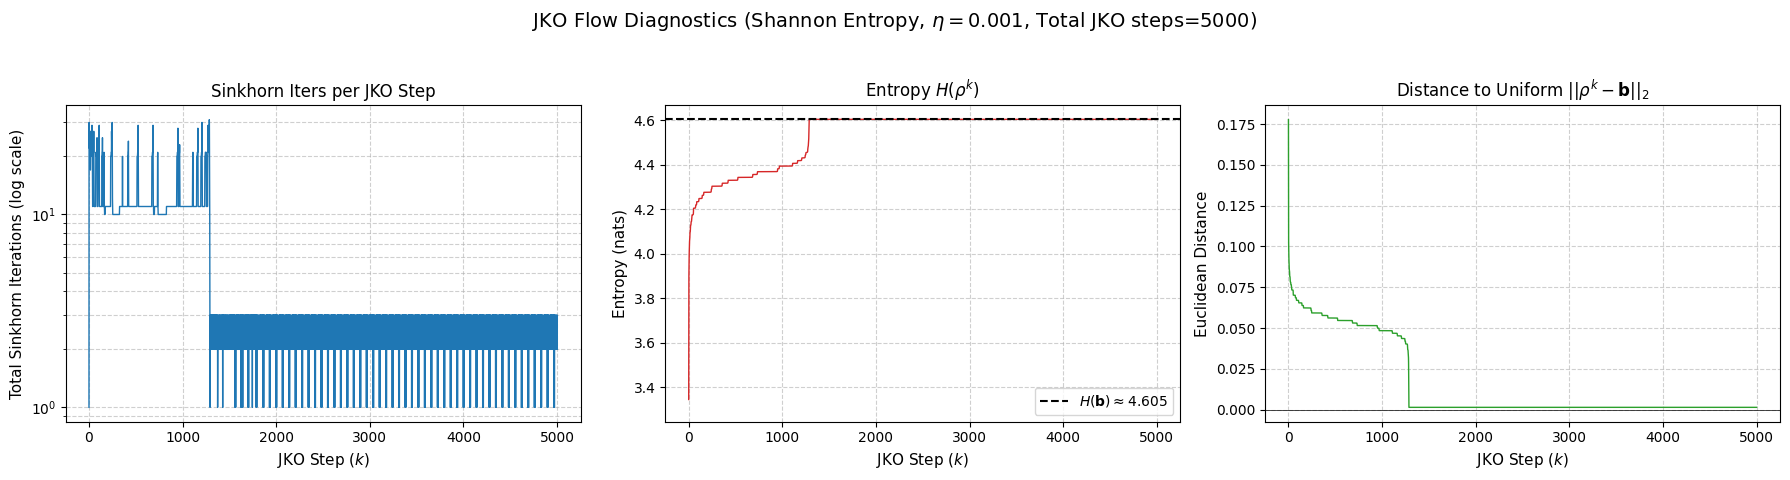

In [26]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step']),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Let's roughly implement the adaptive JKO flow by manually running the flow using semigroup property.

In [16]:
# set two warm start marginals
f_ws = diag['f_final']
g_ws = diag['g_final']

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# set up new hyperparameters
eta = 1e-3                 
epsilon = 1           
sinkhorn_max_iters = 2000 
jko_inner_steps = 10      
jko_tol = 1e-9            
jko_lr = 0.01            
num_jko_steps = 2000       
rho0 = rhos[-1]

jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_value_entropy,
    sinkhorn_iters=sinkhorn_max_iters, 
    inner_steps=jko_inner_steps,       
    tol=jko_tol,              
    learning_rate=jko_lr,
    optimizer_name='sgd'
)

print("Starting JKO flow...")
rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag['sinkhorn_iters_per_jko_step'])

b = jnp.ones_like(x)/n
print("Computing L2 errors of measures...")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing Entropy of measures...")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

Starting JKO flow...
Flow computation finished.
[21 20 16 ...  0  1  0]
Computing L2 errors of measures...
Computing Entropy of measures...

Target Uniform Entropy: 4.605170
[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k=  0: H=4.605142, ||rho-b||=0.000746
 k= 10: H=4.603182, ||rho-b||=0.006265
 k= 50: H=4.603181, ||rho-b||=0.006265
 k=100: H=4.603181, ||rho-b||=0.006265
 k=500: H=4.603181, ||rho-b||=0.006265
 k=1000: H=4.603181, ||rho-b||=0.006265
 k=1999: H=4.603181, ||rho-b||=0.006265


In [8]:
prindt
def adaptive_jko_flow(
        C,
        rho0,
        eta,
        epsilon,
        F_func,
        sinkhorn_max_iters,
        jko_inner_steps,
        jko_tol,
        jko_lr,
        optimizer_name,
        threshold,
        batch_size=100,     # fixed batch size for optimization
        verbose=False       # report progress
    ):
    """
    JKO flow with adaptive choice of JKO stepsize and regularization parameter

    Args:
        threshold: List of steps per phase (e.g., [300, 700, 1500, 2500])
        batch_size: Fixed size for internal batches (default: 100)
        verbose: If True, print progress information
    
    Returns:
        Array of shape (total_steps+1, n) containing trajectory
    """
    import time
    
    current_rho = rho0
    f_ws = None
    g_ws = None
    all_rhos = [rho0]
    
    eta_current = eta
    epsilon_current = epsilon
    total_start = time.time()
    first_batch = True
    
    for phase_idx, n_steps in enumerate(threshold):
        phase_start = time.time()
        
        if verbose:
            print(f"\nPhase {phase_idx + 1}/{len(threshold)}: {n_steps} steps")
            print(f"  τ={eta_current:.2e}, ε={epsilon_current:.2e}")
            if first_batch:
                print(f"  First batch will trigger JIT compilation...")
        
        # Process this phase in fixed-size batches
        steps_remaining = n_steps
        
        while steps_remaining > 0:
            # Create flow object for current batch
            jko_flow = SinkhornJKO(
                C=C,
                rho0=current_rho,
                eta=eta_current,
                epsilon=epsilon_current,
                F_func=F_func,
                sinkhorn_iters=sinkhorn_max_iters,
                inner_steps=jko_inner_steps,
                tol=jko_tol,
                learning_rate=jko_lr,
                optimizer_name=optimizer_name
            )
            
            # Always use batch_size for JIT consistency
            rhos, diag = jko_flow.compute_flow(
                num_steps=batch_size,
                f_init=f_ws,
                g_init=g_ws
            )
            
            first_batch = False
            
            # Extract only the steps we need
            actual_steps = min(steps_remaining, batch_size)
            all_rhos.extend(rhos[1:actual_steps + 1])
            
            # Update for next iteration
            current_rho = rhos[actual_steps]
            f_ws = diag['f_final']
            g_ws = diag['g_final']
            
            steps_remaining -= actual_steps
        
        if verbose:
            phase_time = time.time() - phase_start
            print(f"  Completed in {phase_time:.2f}s")
        
        # Update parameters for next phase
        eta_current = eta_current
        epsilon_current = epsilon_current / 5
    
    if verbose:
        total_time = time.time() - total_start
        print(f"\nTotal time: {total_time:.2f}s")
        print(f"Total steps: {sum(threshold)}")
    
    return jnp.array(all_rhos)

# Choose F = entropy (negative Boltzmann-Shannon)
def F_value_entropy(rho: jax.Array) -> jax.Array:
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe)) - 1.0)

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

eta = 1e-3                 
epsilon = 1e-1            
sinkhorn_max_iters = 2000 
jko_inner_steps = 10      
jko_tol = 1e-6            
jko_lr = 0.01            
num_jko_steps = 5000       
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

rhos = adaptive_jko_flow(
        C=C,
        rho0=rho0,
        eta=eta,
        epsilon=epsilon,
        F_func=F_value_entropy,
        sinkhorn_max_iters=sinkhorn_max_iters,
        jko_inner_steps=jko_inner_steps,
        jko_tol=jko_tol,
        jko_lr=jko_lr,
        optimizer_name='adam',
        threshold=[3000, 2000],
        batch_size=100,  # NEW: Optional parameter
        verbose=True      # NEW: Optional parameter
    )

b = jnp.ones_like(x)/n
print("Computing errors")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing entropy")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

NameError: name 'prindt' is not defined

In [ ]:
x = jnp.linspace(0.0, 1.0, n)

html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (Shannon Entropy)"
)
html

#### Kullback-Leibler Divergence Flow
Kullback-Leibler (KL) divergence is defined by $$\mathcal{F}[\rho] = \int_\Omega V d\rho + \int_\Omega \rho\log\rho d\rho.$$ As the JKO stepsize $\tau \to 0$, Wasserstein gradient flow approximates the Fokker-Planck equation. Upon discretization, we get
$$F[\rho] = \sum_{i=1}^{n} V_i \rho_i + \sum_{i=1}^{n} \rho_i \log \rho_i$$
with $V \in \mathbb{R}^n$.

#### Porous Media Equation
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho]=\frac{1}{m-1}\int_{\Omega}\rho^m d\rho,$$ for $m\geq 1$. The corresponding JKO flow is defined as
$$
\rho^{k+1} = \underset{\rho\in\mathcal{P}(\Omega)}{\arg\min}\left\{ \frac{1}{m-1}\int_{\Omega}\rho^m d\rho + \frac{W_2^2(\rho,\rho^k)}{2\eta} \right\}
$$
for each $k \geq 1$. Then, as the JKO stepsize $\tau \to 0$, this Wasserstein gradient flow approximates the Porous media equation given by
$$\partial_t \rho_t = \nabla^2 \mathcal{F}(\rho) = \nabla \cdot (\nabla \mathcal{F}(\rho))$$

Upon discretization, we get
$$F[\rho] = \frac{1}{m-1}\sum_{i=1}^{n} \rho_i^m$$

with $m \in \mathbb{N}$.

In [ ]:
def F_porous_media(rho, m=2):
    return jnp.sum(jnp.power(rho, m)) /(m-1)

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

eta = 0.1                 # Reasonable JKO time step (1/eta = 20)
epsilon = 1e-3            # Fine-grained OT regularization
sinkhorn_max_iters = 2000 # Give Sinkhorn *plenty* of room to converge
jko_inner_steps = 10      # Fewer inner steps, but with good gradients
jko_tol = 1e-6            # Relaxed tolerance
jko_lr = 0.005            # More stable inner learning rate
num_jko_steps = 200       # Total time T = 200 * 0.1 = 20
# -------------------------------
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
# Now normalize
rho0 = jnp.clip(rho0, 1e-8, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))


In [ ]:
jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_porous_media,
    sinkhorn_iters=sinkhorn_max_iters, # Use the new value
    inner_steps=jko_inner_steps,       # Use the new value
    tol=jko_tol,                       # Use the new value
    learning_rate=jko_lr,              # Use the new value
    optimizer_name='adam'
)

print("Starting JKO flow...")
# rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag)

b = jnp.ones_like(x)/n
print("Computing errors")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing entropy")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
# Print steps 0, 1, 5, 10, 20, 30, 40, 49
k_steps_to_print = [i for i in [0, 1, 5, 10, 20, 30, 40, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

# This check is just for the last step
if k_steps_to_print:
    k_last = k_steps_to_print[-1]
    print(f" k={k_last:3d}: H={float(Hs[k_last]):.6f}, ||rho-b||={float(dists[k_last]):.6f}")

print("\nGenerating animation (this may take a moment)...")

#### $\chi$-square Divergence Flow
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} \left(\frac{d\rho}{d\nu}-1\right)d\nu$$ where $\rho$ is absolutely continuous with respect to $\nu$. By Radon-Nikodym theorem, $\rho$ admits a density, i.e. Radon-Nikodym derivative $\frac{d\rho}{d\nu}$. Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} \frac{\rho_i}{\nu_i} - 1$$

In [ ]:
b = # take a reference measure b = nu



#### Porous Media Divergence Flow
Let $V$ be a lower bounded, lower semicontinuous, and convex function. Let $\mathcal{F}[\rho]$ be an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} V d\rho + \frac{1}{m-1}\int_{\Omega} \rho^m d\rho$$ for some $m \geq 1$. If $V=0$ is identically zero, then porous media divergence is equivalent to the potential given in porous media equation. Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} V_i \rho_i + \frac{1}{m-1}\sum_{i=1}^{n} \rho^m_{i}$$ for a given $m \geq 1$.

In [ ]:
def F_porous_divergence(rho, V, m):
    """
    Porous Media Divergence of rho given m >= 1 and potential vector V
    """
    if V is None:
        V = jnp.zeros_like(rho) # by default, zero potential

    return jnp.dot(V,rho)+(jnp.sum(jnp.power(rho,m)))/(m-1)



Let us test $F[\rho]$ for multiple potential functions $V$. If $V(x)=||x||^2$, then